<a href="https://colab.research.google.com/github/merrillm1/sentiment_analysis_with_ULMFiT/blob/master/Yelp_Sentiment_Analysis_with_ULMFiT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [2]:
%tensorflow_version 2.x
import tensorflow as tf
import timeit

In [3]:
%matplotlib inline
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from fastai.metrics import accuracy
from fastai.text import *
from fastai import *

In [4]:
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [5]:
import glob
df_names = ['test', 'train']
links = ['https://drive.google.com/file/d/1zD8AJ95_LgXZM23S16MSiiXr1IboFlcA', 
         'https://drive.google.com/file/d/12u0obCxGHe3l1MbeWId08FBQhVcEVMNK']
for name, link in zip(df_names, links):
  fluff, id = link.split('d/')
  downloaded = drive.CreateFile({'id':id}) 
  downloaded.GetContentFile(name + '.csv')  
  globals()[name] = pd.read_csv(name+'.csv', 
                                header=None, 
                                names = ['sentiment', 'text'])

In [6]:
print(train.info())
train.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 560000 entries, 0 to 559999
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   sentiment  560000 non-null  int64 
 1   text       560000 non-null  object
dtypes: int64(1), object(1)
memory usage: 8.5+ MB
None


,sentiment,text
0,1,"Unfortunately, the frustration of being Dr. Go..."
1,2,Been going to Dr. Goldberg for over 10 years. ...
2,1,I don't know what Dr. Goldberg was like before...
3,1,I'm writing this review to give you a heads up...
4,2,All the food is great here. But the best thing...


In [7]:
print(test.info())
test.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 38000 entries, 0 to 37999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   sentiment  38000 non-null  int64 
 1   text       38000 non-null  object
dtypes: int64(1), object(1)
memory usage: 593.9+ KB
None


,sentiment,text
0,2,"Contrary to other reviews, I have zero complai..."
1,1,Last summer I had an appointment to get new ti...
2,2,"Friendly staff, same starbucks fair you get an..."
3,1,The food is good. Unfortunately the service is...
4,2,Even when we didn't have a car Filene's Baseme...


In [8]:
sample_size = 10000
train_sample = train.groupby('sentiment').apply(lambda x: x.sample(sample_size))[['sentiment', 'text']]\
                                         .reset_index(drop=True)

## Fellowship ai Challenge Description

Perform Sentiment analysis using ULMFiT on Yelp reviews - Polarity and apply the EDA augmentation. Report the performance metrics for before and after augmentation? show examples of data augmentaion?

## Exploratory Analysis

Before processing with ULMFiT let's perform some expoloratory analysis to find out most common words, in the process we will also clean the text of urls and lower the case of all words to avoid unnecessary repeats. 

In [9]:
import itertools
import collections

import nltk
from nltk.corpus import stopwords
import re
import networkx

import warnings
warnings.filterwarnings("ignore")

sns.set(font_scale=1.5)
sns.set_style("whitegrid")

In [10]:
all_reviews = [text for text in train_sample.text]

In [11]:
all_reviews[:2]

["One of the worst HOB I have been to.  My wife and I went here on a weekday and it wasn't too crowded. Decent looking place. My waitress was nice, but she reminded me of the gal that was on Seinfeld, a low talker.  I could barely hear anything she was saying.  I hoped I didn't misunderstand anything she said and ended up with a meal I didn't order.\\nI ordered a shrimp po' boy.  The shrimp was just okay, no spiceyness to it, but the bread it travelled in was bad.  It literally fell apart when I tried to pick it up. For the price, not even remotely worth it.\\nMy wife ordered a salad.  It was lettuce with a small chunk of blue cheese on the top and dressing on the side.  For nine bucks. And though this is no fault of HOB, my wife didn't like the lettuce offered and she asked for another kind.  They did not offer anything else.\\nVery disappointing meal.  Lots of waitresses and waiters standing around.  It seems like this place is going on it's rock and roll reputation. We will not be b

In [12]:
def remove_url(txt):
    """Replace URLs found in a text string with nothing 
    (i.e. it will remove the URL from the string).

    Parameters
    ----------
    txt : string
        A text string that you want to parse and remove urls.

    Returns
    -------
    The same txt string with url's removed.
    """

    return " ".join(re.sub("([^0-9A-Za-z \t])|(\w+:\/\/\S+)", "", txt).split())

In [13]:
all_reviews_no_urls = [remove_url(text) for text in all_reviews]
all_reviews_no_urls[:2]

['One of the worst HOB I have been to My wife and I went here on a weekday and it wasnt too crowded Decent looking place My waitress was nice but she reminded me of the gal that was on Seinfeld a low talker I could barely hear anything she was saying I hoped I didnt misunderstand anything she said and ended up with a meal I didnt ordernI ordered a shrimp po boy The shrimp was just okay no spiceyness to it but the bread it travelled in was bad It literally fell apart when I tried to pick it up For the price not even remotely worth itnMy wife ordered a salad It was lettuce with a small chunk of blue cheese on the top and dressing on the side For nine bucks And though this is no fault of HOB my wife didnt like the lettuce offered and she asked for another kind They did not offer anything elsenVery disappointing meal Lots of waitresses and waiters standing around It seems like this place is going on its rock and roll reputation We will not be back at least not this location',
 'At first I 

In [14]:
# Create a list of lists containing lowercase words for each tweet
words_in_review = [review.lower().split() for review in all_reviews_no_urls]
all_reviews_lower = [review.lower() for review in all_reviews_no_urls]

In [15]:
# List of all words across tweets
all_words_no_urls = list(itertools.chain(*words_in_review))

In [16]:
# Collections library for python includes the counter function, which we will use here to count the frequency of words
counts_no_urls = collections.Counter(all_words_no_urls)
counts_no_urls.most_common(15)

[('the', 131039),
 ('and', 86371),
 ('i', 68580),
 ('to', 67016),
 ('a', 66898),
 ('was', 47248),
 ('of', 39575),
 ('it', 33660),
 ('for', 30719),
 ('in', 29764),
 ('is', 29493),
 ('that', 24884),
 ('my', 23974),
 ('we', 21286),
 ('this', 21166)]

> Let's remove the stop words and analyze the top words again. This may give us more insight into the text.

In [17]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [18]:
stop_words = set(stopwords.words('english'))

In [19]:
# Remove stop words from each review list of words
reviews_nsw = [[word for word in review_words if not word in stop_words]
              for review_words in words_in_review]

In [20]:
# let's take a look again at the most common words
all_words_nsw = list(itertools.chain(*reviews_nsw))

counts_nsw = collections.Counter(all_words_nsw)

counts_nsw.most_common(15)

[('food', 11422),
 ('place', 11329),
 ('good', 10170),
 ('like', 9144),
 ('one', 8304),
 ('get', 8297),
 ('great', 7442),
 ('service', 7416),
 ('time', 7385),
 ('would', 7334),
 ('back', 6886),
 ('go', 6239),
 ('really', 5944),
 ('us', 5425),
 ('dont', 5036)]

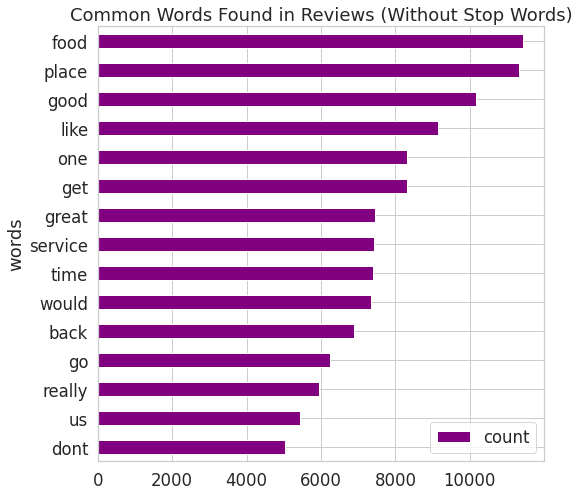

In [21]:
clean_reviews_nsw = pd.DataFrame(counts_nsw.most_common(15),
                             columns=['words', 'count'])

fig, ax = plt.subplots(figsize=(8, 8))

# Plot horizontal bar graph
clean_reviews_nsw.sort_values(by='count').plot.barh(x='words',
                      y='count',
                      ax=ax,
                      color="purple")

ax.set_title("Common Words Found in Reviews (Without Stop Words)")

plt.show()

In [22]:
all_reviews_lower[:2]

['one of the worst hob i have been to my wife and i went here on a weekday and it wasnt too crowded decent looking place my waitress was nice but she reminded me of the gal that was on seinfeld a low talker i could barely hear anything she was saying i hoped i didnt misunderstand anything she said and ended up with a meal i didnt orderni ordered a shrimp po boy the shrimp was just okay no spiceyness to it but the bread it travelled in was bad it literally fell apart when i tried to pick it up for the price not even remotely worth itnmy wife ordered a salad it was lettuce with a small chunk of blue cheese on the top and dressing on the side for nine bucks and though this is no fault of hob my wife didnt like the lettuce offered and she asked for another kind they did not offer anything elsenvery disappointing meal lots of waitresses and waiters standing around it seems like this place is going on its rock and roll reputation we will not be back at least not this location',
 'at first i 

In [23]:
train_sample['clean_text'] = all_reviews_lower

In [24]:
train_unprocessed = train_sample[['sentiment', 'text']]
train_processed = train_sample[['sentiment', 'clean_text']]

In [25]:
from sklearn.model_selection import train_test_split

# Split into training and test
train_raw, test_raw = train_test_split(train_unprocessed,test_size=0.2,random_state=3)
train_clean, test_clean = train_test_split(train_processed,test_size=0.2,random_state=3)

In [26]:
train_raw.to_csv('train_raw.csv', index=0)
test_raw.to_csv('test_raw.csv', index=0)
train_clean.to_csv('train_clean.csv', index=0)
test_clean.to_csv('test_clean.csv', index=0)

In [27]:
from fastai.text import *
#dls = data.TextDataLoaders.from_df(df, path='', text_col='text', is_lm=True, label_col='sentiment')
review_raw = TextLMDataBunch.from_csv(path='',csv_name='train_raw.csv',valid_pct=0.1)

In [28]:
review_raw.show_batch()

idx,text
0,"wrong . xxmaj the hot peppers were not xxunk but just marinated jalape \ u00f1os . "" xxmaj dipped "" here apparently means just xxunk some jus onto the beef . xxmaj regardless , had it been actually dipped , the jus would have made it way too salty . \n \n xxmaj saw them making burgers on the grill . xxmaj not hand - formed , looked frozen"
1,'s has some serious issues that they need to work on . i wo n't be returning anytime soon as there are too many good options in xxmaj cave xxmaj creek that have their act together . xxbos xxmaj probably my least favorite club in xxmaj vegas . xxmaj even with a table it becomes too crowded and when xxmaj vegas is over 110 a small over crowded club becomes
2,"upset over the fact that i was not fully informed of their ticket purchasing policy , and how inflexible every single person was . xxmaj not one person had any compassion about my xxunk and just kept telling me , it 's their policy . xxmaj yes i understand the merits of policies and you have to have them to have structure and order especially running a huge establishment ,"
3,"has had and is consistently well trimmed and has had good flavor each time he 's ordered it . \n \n a few other things worthy of mention : \n xxmaj maryland crab cakes ( full of crab and the apple relish served with it is fresh and a really good xxunk ) , and the creamy chicken noodle soup ( only served one day a week but"
4,"factory , but we think it 's better . xxmaj the portions are xxunk and the prices are cheap . xxup this xxup is a xxup bad xxup place xxup for a xxup diet ! xxmaj we were in xxmaj las xxmaj vegas over xxmaj thanksgiving and ate here the on xxmaj thanksgiving xxmaj eve . xxmaj like xxmaj the xxmaj cheesecake xxmaj factory , they have a large variety"


In [29]:
raw_model = language_model_learner(review_raw, AWD_LSTM, drop_mult=0.3)

In [30]:
raw_model.model

SequentialRNN(
  (0): AWD_LSTM(
    (encoder): Embedding(21376, 400, padding_idx=1)
    (encoder_dp): EmbeddingDropout(
      (emb): Embedding(21376, 400, padding_idx=1)
    )
    (rnns): ModuleList(
      (0): WeightDropout(
        (module): LSTM(400, 1152, batch_first=True)
      )
      (1): WeightDropout(
        (module): LSTM(1152, 1152, batch_first=True)
      )
      (2): WeightDropout(
        (module): LSTM(1152, 400, batch_first=True)
      )
    )
    (input_dp): RNNDropout()
    (hidden_dps): ModuleList(
      (0): RNNDropout()
      (1): RNNDropout()
      (2): RNNDropout()
    )
  )
  (1): LinearDecoder(
    (decoder): Linear(in_features=400, out_features=21376, bias=True)
    (output_dp): RNNDropout()
  )
)

In [31]:
raw_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 3.98E-02
Min loss divided by 10: 1.45E-02


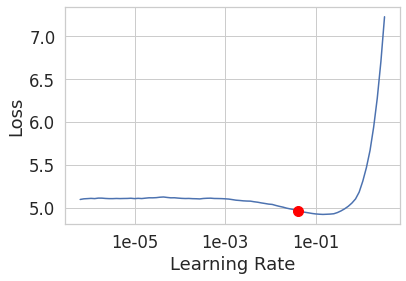

In [32]:
raw_model.recorder.plot(show_grid=True, suggestion=True)

In [33]:
raw_model.fit_one_cycle(cyc_len=1,max_lr=3.98E-02,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,4.208251,4.025140,0.270467,02:04


In [34]:
raw_model.unfreeze()

In [35]:
raw_model.fit_one_cycle(cyc_len=5, max_lr=slice(3.98E-02/(2.6**4),3.98E-02), moms=(0.85, 0.75))

epoch,train_loss,valid_loss,accuracy,time
0,3.963167,3.962052,0.276487,02:37
1,3.907503,3.892173,0.283918,02:37
2,3.648359,3.789534,0.296000,02:37
3,3.273543,3.749079,0.302261,02:37
4,2.867759,3.841619,0.299140,02:36


In [36]:
raw_model.save_encoder('encoder')

In [37]:
raw_class = TextClasDataBunch.from_csv(path='',csv_name='train_raw.csv',
                              vocab=review_raw.train_ds.vocab,bs=32,text_cols='text',label_cols='sentiment')

In [38]:
raw_class.show_batch()

text,target
"xxbos xxup worst hotel experience of my xxup life ! ! "" xxmaj why "" nice people of xxunk ask ? i am not a xxunk to please type person - i can do it "" up "" or i am can be fine in a motel xxup but i am a stickler for nice service ! ! i just think the whole xxup hotel needs a staff makeover !",1
"xxbos i have been a xxmaj harley owner for 10 years , and have owned 3 different xxmaj harley 's . i 've frequented several xxmaj harley shops trying to find the ones that provide the best and most convenient service . i used to be able to say this about xxmaj red xxmaj rock xxmaj harley , however , over the last six months , i 've had nothing",1
"xxbos xxmaj short story : the guy smeared the sole rubber all over the shaft of my boots , said he did n't do it , tried to clean it up and took out some of the leather 's dye instead , and did n't give me a refund ( i 'd already paid ) . xxmaj moral the story : if you risk this dude , only pay him",1
"xxbos xxmaj this school is sort of right down the middle in teaching quality and facilities . xxmaj classes , instructors , xxunk , all seem to fall into the "" xxmaj ok "" rating . \n \n xxmaj at least the student worker staff and faculty are genuinely helpful , likely because xxup unlv usually exceeds all other places in xxmaj hospitality xxmaj management degrees . xxmaj it",1
"xxbos xxmaj so , \n \n xxmaj it 's done , i completed the 4 days on xxmaj friday and it was pretty good . i learned a lot and hopefully am a little smoother and faster now . xxmaj the total cost was xxunk for the 3 day school which i extended to 4 days at xxunk xxup xxunk . i paid 300 dollars for insurance ( still",2


In [39]:
raw_model = text_classifier_learner(raw_class, AWD_LSTM, drop_mult=0.5)

In [40]:
raw_model.load_encoder('encoder')

RNNLearner(data=TextClasDataBunch;

Train: LabelList (12799 items)
x: TextList
xxbos xxmaj unique location and amazing food ! xxmaj this little gem is hidden in the corner of the xxmaj antiques xxmaj market . xxmaj they have only been open about 2 weeks but i predict xxunk for this cafe . xxmaj the chef , xxmaj jackie xxmaj lim , is a transplant from xxup nyc and has brought her signature bacon jam to xxmaj vegas . xxmaj rumor on the street that she cooked for xxmaj bill xxmaj clinton ... well there 's also a picture on the wall =) xxmaj the style comes across as comfort food with an xxmaj asian touch , done with a rustic twist . xxmaj the meal starts with complimentary chips and home made garlic hummus . xxmaj after stalking the xxmaj yelp reviews , we settled on the xxup tnb signature burger and the xxmaj the xxmaj ryan ( panini with brisket ) . xxmaj however , other options were quite tantalizing as well , such as the xxmaj chicharron cobb salad ... and i do n't even like salad . xx

In [41]:
raw_model.model

SequentialRNN(
  (0): MultiBatchEncoder(
    (module): AWD_LSTM(
      (encoder): Embedding(21376, 400, padding_idx=1)
      (encoder_dp): EmbeddingDropout(
        (emb): Embedding(21376, 400, padding_idx=1)
      )
      (rnns): ModuleList(
        (0): WeightDropout(
          (module): LSTM(400, 1152, batch_first=True)
        )
        (1): WeightDropout(
          (module): LSTM(1152, 1152, batch_first=True)
        )
        (2): WeightDropout(
          (module): LSTM(1152, 400, batch_first=True)
        )
      )
      (input_dp): RNNDropout()
      (hidden_dps): ModuleList(
        (0): RNNDropout()
        (1): RNNDropout()
        (2): RNNDropout()
      )
    )
  )
  (1): PoolingLinearClassifier(
    (layers): Sequential(
      (0): BatchNorm1d(1200, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (1): Dropout(p=0.2, inplace=False)
      (2): Linear(in_features=1200, out_features=50, bias=True)
      (3): ReLU(inplace=True)
      (4): BatchNorm1d(50, 

In [42]:
raw_model.lr_find()

epoch,train_loss,valid_loss,accuracy,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 1.74E-03
Min loss divided by 10: 2.09E-02


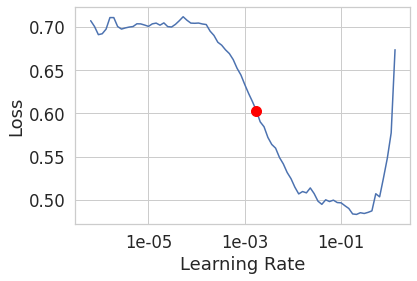

In [43]:
raw_model.recorder.plot(show_grid=True, suggestion=True)

In [44]:
raw_model.fit_one_cycle(cyc_len=1,max_lr=1.74E-03,moms=(0.85,0.75))

epoch,train_loss,valid_loss,accuracy,time
0,0.270082,0.190019,0.926898,00:54


In [45]:
raw_model.freeze_to(-2)

In [46]:
raw_model.fit_one_cycle(5,slice(1.74E-03/(2.6**4),1.74E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.253153,0.190775,0.924086,01:21
1,0.253208,0.163169,0.933146,01:19
2,0.206931,0.156035,0.936582,01:01
3,0.207744,0.154875,0.940331,01:12
4,0.171847,0.152281,0.938144,01:08


In [47]:
raw_model.freeze_to(-3)
raw_model.fit_one_cycle(5,slice(1.74E-03/(2.6**4),1.74E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.176959,0.156303,0.940644,01:54
1,0.183453,0.153435,0.940956,01:52
2,0.150118,0.150454,0.942830,01:39
3,0.112493,0.152493,0.945017,01:43
4,0.093958,0.156285,0.943143,01:50


In [48]:
raw_model.unfreeze()
raw_model.fit_one_cycle(5,slice(1.74E-03/(2.6**4),1.74E-03))

epoch,train_loss,valid_loss,accuracy,time
0,0.101568,0.156963,0.946267,02:11
1,0.104633,0.156372,0.945017,02:17
2,0.088844,0.165443,0.943455,02:36
3,0.059252,0.173688,0.946267,02:43
4,0.055275,0.167179,0.948766,02:07


In [49]:
test_raw['yelp_senti_pred'] = test_raw['text'].apply(lambda row:str(raw_model.predict(row)[0]))

In [55]:
test_raw['yelp_senti_pred'] = test_raw['yelp_senti_pred'].astype(str).astype(int)

In [56]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

In [57]:
print("Accuracy of Model: {}".format(accuracy_score(test_raw['sentiment'],test_raw[
    'yelp_senti_pred'])))

Accuracy of Model: 0.95


In [53]:
test_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4000 entries, 1406 to 16048
Data columns (total 3 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   sentiment        4000 non-null   int64 
 1   text             4000 non-null   object
 2   yelp_senti_pred  4000 non-null   object
dtypes: int64(1), object(2)
memory usage: 125.0+ KB


In [58]:
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(test_raw['sentiment'], test_raw['yelp_senti_pred'])
print(cf_matrix)

[[1889  120]
 [  80 1911]]
